# Mini-Project: SVM&LR Classification

Team Members: Joe Schueder, Armando Vela, Jeff Washburn, Daniel Clark


You are to perform predictive analysis (classification) upon a data set: model the dataset using
methods we have discussed in class: logistic regression & support vector machines and making
conclusions from the analysis. Follow the CRISP-DM framework in your analysis (you are not
performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined
below). This report is worth 10% of the final grade. You may complete this assignment in teams
of as many as three people.
Write a report covering all the steps of the project. The format of the document can be PDF,
*.ipynb, or HTML. You can write the report in whatever format you like, but it is easiest to turn in
the rendered Jupyter notebook. The results should be reproducible using your report. Please
carefully describe every assumption and every step in your report.
A note on grading: A common mistake I see in this lab is not investigating different input
parameters for each model. Try a number of parameter combinations and discuss how the model changed. 

## SVM and Logistic Regression Modeling


### Create Models [50 points] 
Create a logistic regression model and a support vector machine model for the
classification task involved with your dataset. Assess how well each model performs (use
80/20 training/testing split for your data). Adjust parameters of the models to make them
more accurate. If your dataset size requires the use of stochastic gradient descent, then
linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing
logistic regression and linear support vector machines. For many problems, SGD will be
required in order to train the SVM model in a reasonable timeframe.   

In [0]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [0]:
#read data from github repository
#this data was produced from the Iowa Alcohol Dataset 2019 year data
#It was cleansed and transformed in this notebook and exported as a csv to github for use here.
#source python notebook: https://github.com/jjschueder/7331DataMiningNotebooks/blob/master/lab1/msds7331_clark_schueder_vela_washburn.ipynb
# read csv from github directly
url_dataset = 'https://github.com/jjschueder/7331DataMiningNotebooks/blob/master/Live%20Assignment%201/df1hotmerge2.csv?raw=true'
#df = pd.read_csv(url_dataset, nrows=50000)
data = pd.read_csv(url_dataset)

In [4]:
print(data.shape)
print(list(data.columns))

(400000, 68)
['Unnamed: 0', 'pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'counter', 'liquor_category', 'store_parent', 'month', 'year', 'monthyear', 'liquor_category_AMARETTO', 'liquor_category_BRANDY', 'liquor_category_GIN', 'liquor_category_LIQUEUR', 'liquor_category_Other', 'liquor_category_RUM', 'liquor_category_SCHNAPPS', 'liquor_category_TEQUILA', 'liquor_category_VODKA', 'liquor_category_WHISKY', 'store_parent_CVS', 'store_parent_Caseys', 'store_parent_Hy-Vee', 'store_parent_Kum&Go', 'store_parent_Other', 'store_parent_QuikTrip', 'store_parent_SamsClub', 'store_parent_SmokingJoes', 'store_parent_Target', 'store_parent_Wal-Mart', 'store_parent_Walgreens', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'year_2019', 'monthyear_Apr-2019', 'monthyear_Aug-2019', 'monthyear_De

In [5]:
data = data.drop(columns = ['Unnamed: 0'])
count_not_whiskey = len(data[data['liquor_category_WHISKY']==0])
count_whiskey = len(data[data['liquor_category_WHISKY']==1])
pct_of_no_whiskey = count_not_whiskey/(count_not_whiskey+count_whiskey)
print("percentage of not whiskey is", pct_of_no_whiskey*100)
pct_of_whiskey = count_whiskey/(count_not_whiskey+count_whiskey)
print("percentage of whiskey", pct_of_whiskey*100)

percentage of not whiskey is 89.56125
percentage of whiskey 10.438749999999999


**For teams to discuss tonight. A 10% representation of whiskey is going to make running a logistic regression model a little tricky. With this distribution, a model can simply classify 0 for every instance and get a 89% accuracy rate, which isn't necessarily rewarding it's machine learning technique for accurately guessing Whiskies. It is also going to make our AUC no skill lines kind of misleading.**

https://stats.stackexchange.com/questions/66753/do-i-need-a-balanced-sample-50-yes-50-no-to-run-logistic-regression

**It might be worth subsetting our distribution so that we have closer to 50% whiskies and 50% non whiskies so we can actually test which is driving performance. Alternatively, we can make our models cost sensitive as per the blow and weight them by a 1:10 ratio**

https://machinelearningmastery.com/cost-sensitive-logistic-regression/

In [7]:
cat_vars=['counter', 'liquor_category', 'store_parent',
 'month', 'year', 'monthyear', 'liquor_category_AMARETTO', 'liquor_category_BRANDY', 'liquor_category_GIN', 
 'liquor_category_LIQUEUR', 'liquor_category_Other', 'liquor_category_RUM', 'liquor_category_SCHNAPPS', 
 'liquor_category_TEQUILA', 'liquor_category_VODKA', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb',
 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

data_final=data[to_keep]
data_final.columns.values

array(['pack', 'bottle_volume_ml', 'state_bottle_cost',
       'state_bottle_retail', 'bottles_sold', 'sale_dollars',
       'volume_sold_liters', 'volume_sold_gallons',
       'liquor_category_WHISKY', 'store_parent_CVS',
       'store_parent_Caseys', 'store_parent_Hy-Vee',
       'store_parent_Kum&Go', 'store_parent_Other',
       'store_parent_QuikTrip', 'store_parent_SamsClub',
       'store_parent_SmokingJoes', 'store_parent_Target',
       'store_parent_Wal-Mart', 'store_parent_Walgreens', 'year_2019',
       'monthyear_Apr-2019', 'monthyear_Aug-2019', 'monthyear_Dec-2019',
       'monthyear_Feb-2019', 'monthyear_Jan-2019', 'monthyear_Jul-2019',
       'monthyear_Jun-2019', 'monthyear_Mar-2019', 'monthyear_May-2019',
       'monthyear_Nov-2019', 'monthyear_Oct-2019', 'monthyear_Sep-2019',
       'sale_dollars_trans', 'cost_per_liter', 'cost_per_liter_trans',
       'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans', 'grossmargin'], dtype=object)

#### Logistic Regression model:

In [27]:
X = data_final.loc[:, data_final.columns != 'liquor_category_WHISKY']
y = data_final.loc[:, data_final.columns == 'liquor_category_WHISKY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
columns = X_train.columns


from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
#weights = {0:1.0, 1:10.0}
logisticRegr = LogisticRegression()#solver='lbfgs', class_weight=weights)

logisticRegr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
coef = logisticRegr.coef_[0]
classes = logisticRegr.classes_[0]
intercept = logisticRegr.intercept_[0]
print (coef)

[-0.03503136 -0.00312428  0.09952419  0.09050761 -0.06084592  0.00447377
 -0.04482224 -0.0115786   0.00534906 -0.04094758  0.12478778 -0.06495808
 -0.09594336 -0.0179852   0.00650752 -0.02161384  0.00125703 -0.01336544
 -0.00467172 -0.12158383 -0.0376673   0.02253846 -0.01580206 -0.00716828
 -0.02492801 -0.03349421 -0.02633979  0.01178798 -0.02166746  0.00045236
  0.00524361  0.00546087 -0.1184619  -0.00797666 -0.26406154  0.01706717
 -0.08576726  0.14559964 -0.04086942]


In [29]:
intercept

-0.12158640934801339

In [30]:
# Returns a NumPy Array
predictions = logisticRegr.predict(X_test)

params =logisticRegr.get_params(deep=True)
params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [31]:
decfunct = pd.DataFrame(logisticRegr.decision_function(X_test))
decfunct

,0
0,-3.194613
1,0.237582
2,-4.106625
3,-2.767125
4,-2.917561
...,...
79995,-1.819173
79996,-6.328866
79997,-5.640552
79998,-4.135136


In [32]:
# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
print(score)

0.9208375


Doing a quick comparision against the raw distribution of our dataset and our classification model, we can see that our logistic regression model accuracy 92% was better than if our model selected 0 for each datapoint (89%).


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
print("Confusion Matrix: ", '\n', cm)

Confusion Matrix:  
 [[70466  1211]
 [ 5122  3201]]


ROC Curves and AUC in Python
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

When to Use ROC vs. Precision-Recall Curves? Generally, the use of ROC curves and precision-recall curves are as follows:

ROC curves should be used when there are roughly equal numbers of observations for each class. Precision-Recall curves should be used when there is a moderate to large class imbalance.

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# predict probabilities
lr_probs = logisticRegr.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.903


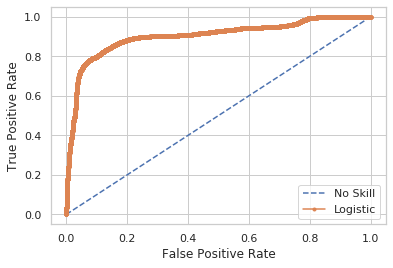

In [35]:
from matplotlib import pyplot
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.503 auc=0.645


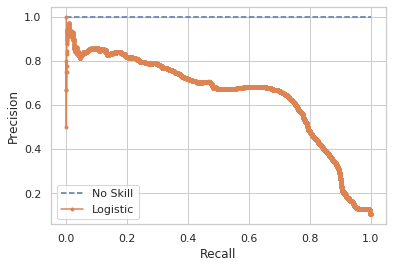

In [36]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
# predict probabilities
lr_probs = logisticRegr .predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = logisticRegr .predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [0]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Separating out the features
x = data.loc[:, to_keep].values
# Separating out the target
y = data.loc[:,['liquor_category_WHISKY']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=28)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
#             , columns = ['principal component 1', 'principal component 2', '3',
#                         '4', '5'])


pca.explained_variance_ratio_
finalDf = pd.concat([principalDf, data[['liquor_category_WHISKY']]], axis = 1)

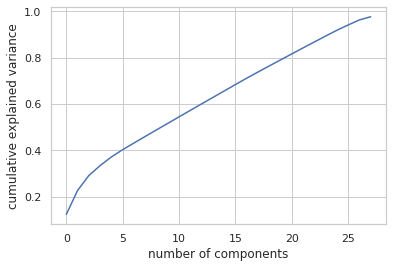

In [39]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

#### Logistic regression with PCA

In [0]:
#X = finalDf.loc[:, finalDf.columns != 'liquor_category_WHISKY']
#y = finalDf.loc[:, finalDf.columns == 'liquor_category_WHISKY']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
#columns = X_train.columns

In [0]:
#X = data_final.loc[:, data_final.columns != 'liquor_category_WHISKY']
#y = data_final.loc[:, data_final.columns == 'liquor_category_WHISKY']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#columns = X_train.columns


from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

logisticRegr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
X_train

array([[-0.70982155, -1.63157439, -0.64320084, ...,  0.59122401,
        -1.54368399, -0.0464694 ],
       [-0.70982155,  1.41605401, -0.39959531, ..., -0.05137568,
         0.57302268, -0.0464694 ],
       [-0.70982155,  1.41605401, -0.37252803, ...,  0.96712073,
         1.38548835, -0.0464694 ],
       ...,
       [ 0.00594805,  0.07151207, -0.76008228, ...,  0.59122401,
         0.67177423,  0.12256   ],
       [-0.70982155,  1.41605401,  0.29062036, ...,  0.96712073,
         1.38548835,  0.00793518],
       [ 0.00594805, -0.37666858, -0.85112677, ...,  0.59122401,
         0.45902237,  0.16031095]])

In [0]:
# Returns a NumPy Array
predictions = logisticRegr.predict(X_test)

In [0]:
# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
print(score)

1.0


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
print("Confusion Matrix: ", '\n', cm)

Confusion Matrix:  
 [[71677     0]
 [    0  8323]]


In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# predict probabilities
lr_probs = logisticRegr.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.905


Logistic: f1=1.000 auc=1.000


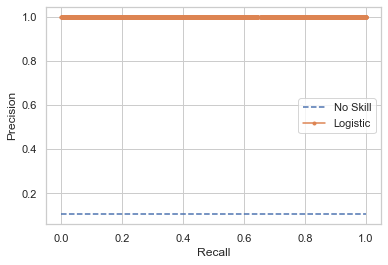

In [0]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
# predict probabilities
lr_probs = logisticRegr .predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = logisticRegr .predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

#### Support Vector Machine Model:

In [0]:
#possibility to scale it?
from sklearn import preprocessing
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

# all parameters not specified are set to their defaults
#https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/
from sklearn.svm import SVC
#svclassifier = SVC(kernel='poly', degree=8)
#svclassifier = SVC(kernel='rbf')
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
# Returns a NumPy Array
predictions = svclassifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[71677     0]
 [    0  8323]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71677
           1       1.00      1.00      1.00      8323

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000



### Advantages  [10 points] 
Discuss the advantages of each model for each classification task. Does one
type of model offer superior performance over another in terms of prediction accuracy? In
terms of training time or efficiency? Explain in detail.  
 


###  Interpret  [30 points] 
Use the weights from logistic regression to interpret the importance of different
features for the classification task. Explain your interpretation in detail. Why do you think
some variables are more important? 

### Insight into the data [10 points]
Look at the chosen support vectors for the classification task. Do these provide
any insight into the data? Explain. If you used stochastic gradient descent (and therefore did
not explicitly solve for support vectors), try subsampling your data to train the SVC model—
then analyze the support vectors from the subsampled dataset. 